### Privatizing Histograms

Sometimes we want to release the counts of individual outcomes in a dataset.
When plotted, this makes a histogram.

The library currently has two approaches:
1. Known category set `make_count_by_categories`
2. Unknown category set `make_count_by`

The next code block imports just handles boilerplate: imports, data loading, plotting.

In [5]:
import os

from opendp.meas import *
from opendp.mod import enable_features, binary_search_chain, Measurement, Transformation
from opendp.trans import *
from opendp.typing import *
enable_features("contrib")
max_influence = 1
budget = (1., 1e-8)

# public information
col_names = ["age", "sex", "educ", "race", "income", "married"]
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
size = 1000

with open(data_path) as input_data:
    data = input_data.read()

def plot_histogram(sensitive_counts, released_counts):
    """Plot a histogram that compares true data against released data"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    plt.ylim([0,225])
    tick_spacing = 1.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.xlim(0,15)
    width = .4

    ax.bar(list([x+width for x in range(0, len(sensitive_counts))]), sensitive_counts, width=width, label='True Value')
    ax.bar(list([x+2*width for x in range(0, len(released_counts))]), released_counts, width=width, label='DP Value')
    ax.legend()
    plt.title('Histogram of Education Level')
    plt.xlabel('Years of Education')
    plt.ylabel('Count')
    plt.show()

### Private histogram via `make_count_by_categories`

This approach is only applicable if the set of potential values that the data may take on is public information.
If this information is not available, then use `make_count_by` instead.
It typically has greater utility than `make_count_by` until the size of the category set is greater than dataset size.
In this data, we know that the category set is public information:
strings consisting of the numbers between 1 and 20.

The counting aggregator computes a vector of counts in the same order as the input categories.
It also includes one extra count at the end of the vector,
consisting of the number of elements that were not members of the category set.

You'll notice that `make_base_geometric` has an additional argument that explicitly sets the type of the domain, `D`.
It defaults to `AllDomain[int]` which works in situations where the mechanism is noising a scalar.
However, in this situation, we are noising a vector of scalars,
and thus the appropriate domain is `VectorDomain[AllDomain[int]]`.

Educational level counts:
 [33, 14, 38, 17, 24, 21, 31, 51, 201, 60, 165, 76, 178, 54, 24, 13, 0, 0, 0]
DP Educational level counts:
 [33, 15, 37, 10, 24, 22, 31, 52, 203, 60, 164, 76, 178, 54, 27, 12, -5, 0, -1]
DP estimate for the number of records that were not a member of the category set: 0


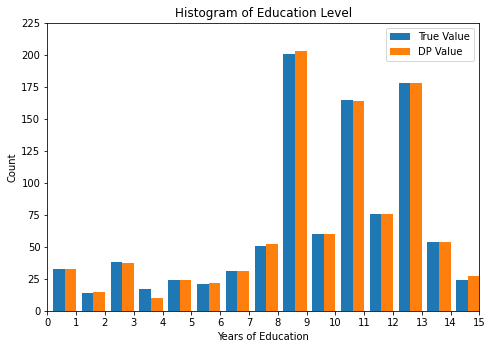

In [6]:
# public information
categories = list(map(str, range(1, 20)))

histogram = (
    make_split_dataframe(separator=",", col_names=col_names) >>
    make_select_column(key="educ", TOA=str) >>
    # Compute counts for each of the categories and null
    make_count_by_categories(categories=categories)
)

noisy_histogram = binary_search_chain(
    lambda s: histogram >> make_base_geometric(scale=s, D=VectorDomain[AllDomain[int]]),
    d_in=max_influence, d_out=budget[0])

sensitive_counts = histogram(data)
released_counts = noisy_histogram(data)

print("Educational level counts:\n", sensitive_counts[:-1])
print("DP Educational level counts:\n", released_counts[:-1])

print("DP estimate for the number of records that were not a member of the category set:", released_counts[-1])

plot_histogram(sensitive_counts, released_counts)

### Private histogram via `make_count_by`
This approach is applicable when the set of categories is unknown or very large.
Any categories with a noisy count less than a given threshold will be censored from the final release.
The noise scale influences the epsilon parameter of the budget, and the threshold influences the delta parameter in the budget.

`ptr` stands for Propose-Test-Release, a framework for censoring queries for which the local sensitivity is greater than some threshold.
Any category with a count sufficiently small is censored from the release.

It is sometimes referred to as a "stability histogram" because it only releases counts for "stable" categories that exist in all datasets that are considered "neighboring" to your private dataset.

I start out by defining a function that finds the tightest noise scale and threshold for which the stability histogram is (d_in, d_out)-close.
You may find this useful for your application.

In [7]:
def make_base_ptr_budget(
        preprocess: Transformation,
        d_in, d_out,
        TK: RuntimeTypeDescriptor) -> Measurement:
    """Make a stability histogram that respects a given d_in, d_out.

    :param preprocess: Transformation
    :param d_in: Input distance to satisfy
    :param d_out: Output distance to satisfy
    :param TK: Type of Key (hashable)
    """
    from opendp.mod import binary_search_param
    from opendp.comb import make_fix_delta
    def privatize(s, t=1e8):
        return make_fix_delta(preprocess >> make_base_ptr(scale=s, threshold=t, TK=TK), d_out[1])
    
    s = binary_search_param(lambda s: privatize(s=s), d_in, d_out)
    t = binary_search_param(lambda t: privatize(s=s, t=t), d_in, d_out)

    return privatize(s=s, t=t)


I now use the `make_count_by_ptr_budget` constructor to release a private histogram on the education data.

The stability mechanism, as currently written, samples from a continuous noise distribution.
If you haven't already, please read about [floating-point behavior in the docs](https://docs.opendp.org/en/latest/user/measurement-constructors.html#floating-point).


Educational level counts:
 [33, 14, 38, 17, 24, 21, 31, 51, 201, 60, 165, 76, 178, 54, 24, 13, 0, 0, 0, 0]
DP Educational level counts:
 {'9': 201, '6': 21, '7': 32, '1': 33, '15': 24, '3': 39, '12': 75, '13': 178, '14': 53, '8': 47, '10': 63, '11': 165, '5': 24}


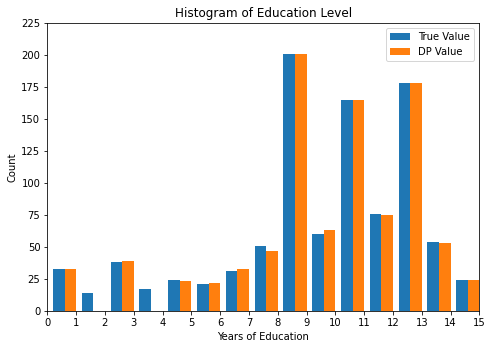

In [8]:

from opendp.mod import enable_features
enable_features("floating-point")

preprocess = (
    make_split_dataframe(separator=",", col_names=col_names) >>
    make_select_column(key="educ", TOA=str) >>
    make_count_by(MO=L1Distance[float], TK=str, TV=float)
)

noisy_histogram = make_base_ptr_budget(
    preprocess,
    d_in=max_influence, d_out=budget,
    TK=str)

sensitive_counts = histogram(data)
released_counts = noisy_histogram(data)
# postprocess to make the results easier to compare
postprocessed_counts = {k: round(v) for k, v in released_counts.items()}

print("Educational level counts:\n", sensitive_counts)
print("DP Educational level counts:\n", postprocessed_counts)

def as_array(data):
    return [data.get(k, 0) for k in categories]

plot_histogram(sensitive_counts, as_array(released_counts))